# Self-Attention Analysis

In [1]:
import sys
%load_ext autoreload
%autoreload 2
#@markdown Execute this cell to import third-party software into the Colab environment.

# check whether it runs in Colab
# root = "."
# if "google.colab" in sys.modules:
#     print("Running in Colab.")
#     !pip3 install timm==0.5.4
#     !pip3 install matplotlib==3.7.1
#     !pip3 install scikit-learn==1.2.2
#     !pip3 install fastai==2.7.12
#     !pip3 install einops==0.6.0
#     !pip3 install gdown==4.7.1
#     !pip3 install yacs==0.1.8    
#     !git clone https://github.com/naver-ai/cl-vs-mim.git
#     root = "./cl-vs-mim"
#     %cd $root

In [2]:
import torch

#@markdown Execute this cell to check the Colab environment, including GPU availability.

# check gpu env
print(f"Torch: {torch.__version__} \n" + 
      f"Availability: {torch.cuda.is_available()}")
assert torch.cuda.is_available() == True, "The GPU is turned off. To turn it on, navigate to: Runtime > Change Runtime Type."
print(f"Number: {torch.cuda.device_count()} \n" +
      f"Current device: {torch.cuda.current_device()} \n" +
      f"First device: {torch.cuda.device(0)} \n" +
      f"Device name: {torch.cuda.get_device_name(0)}")

Torch: 1.13.1 
Availability: True
Number: 1 
Current device: 0 
First device: <torch.cuda.device object at 0x7f858fb81120> 
Device name: Tesla V100-SXM2-32GB


In [3]:
# import os
# import math
# import numpy as np
# from torch.utils.data import DataLoader

# import torchvision.datasets as datasets
# import timm.data.transforms_factory as tff
# from fastai.data.external import untar_data, URLs
# from utils import subsample

# #@markdown Execute this cell to download and import the *Imagenette* dataset, which is a small subset of ImageNet, for simplicity.

# # use imagenette (a small subset of imagenet) as an example for simplicity
# imagenet_path = untar_data(URLs.IMAGENETTE_160)

# imagenet_mean = np.array([0.485, 0.456, 0.406])
# imagenet_std = np.array([0.229, 0.224, 0.225])

# transform_test = tff.transforms_imagenet_eval(
#     img_size=224, mean=imagenet_mean, std=imagenet_std,
# )

# test_dir = os.path.join(imagenet_path, 'val')
# dataset_test = datasets.ImageFolder(test_dir, transform_test)
# dataset_test = torch.utils.data.Subset(
#     dataset_test, 
#     subsample(dataset_test, ratio=math.pow(2,-6))  # use a subsampled batch
# )

# dataset_test = DataLoader(
#     dataset_test, 
#     num_workers=1, 
#     batch_size=64,
# )



In [4]:
import argparse
from configs.utils import populate_defaults
import configs.supported as supported
from utils import set_seed, Logger, BatchLogger, log_config, ParseKwargs, load, initialize_wandb, log_group_data, parse_bool, get_model_prefix, move_to
import wilds


''' Arg defaults are filled in according to examples/configs/ '''
parser = argparse.ArgumentParser()

# Required arguments
parser.add_argument('-d', '--dataset', choices=wilds.supported_datasets, required=True)
parser.add_argument('--algorithm', required=True, choices=supported.algorithms)
parser.add_argument('--root_dir', required=True,
                    help='The directory where [dataset]/data can be found (or should be downloaded to, if it does not exist).')

# Dataset
parser.add_argument('--split_scheme', help='Identifies how the train/val/test split is constructed. Choices are dataset-specific.')
parser.add_argument('--dataset_kwargs', nargs='*', action=ParseKwargs, default={},
                    help='keyword arguments for dataset initialization passed as key1=value1 key2=value2')
parser.add_argument('--download', default=False, type=parse_bool, const=True, nargs='?',
                    help='If true, tries to download the dataset if it does not exist in root_dir.')
parser.add_argument('--frac', type=float, default=1.0,
                    help='Convenience parameter that scales all dataset splits down to the specified fraction, for development purposes. Note that this also scales the test set down, so the reported numbers are not comparable with the full test set.')
parser.add_argument('--version', default=None, type=str, help='WILDS labeled dataset version number.')

# Unlabeled Dataset
parser.add_argument('--unlabeled_split', default=None, type=str, choices=wilds.unlabeled_splits,  help='Unlabeled split to use. Some datasets only have some splits available.')
parser.add_argument('--unlabeled_version', default=None, type=str, help='WILDS unlabeled dataset version number.')
parser.add_argument('--use_unlabeled_y', default=False, type=parse_bool, const=True, nargs='?', 
                    help='If true, unlabeled loaders will also the true labels for the unlabeled data. This is only available for some datasets. Used for "fully-labeled ERM experiments" in the paper. Correct functionality relies on CrossEntropyLoss using ignore_index=-100.')

# Loaders
parser.add_argument('--loader_kwargs', nargs='*', action=ParseKwargs, default={})
parser.add_argument('--unlabeled_loader_kwargs', nargs='*', action=ParseKwargs, default={})
parser.add_argument('--train_loader', choices=['standard', 'group'])
parser.add_argument('--uniform_over_groups', type=parse_bool, const=True, nargs='?', help='If true, sample examples such that batches are uniform over groups.')
parser.add_argument('--distinct_groups', type=parse_bool, const=True, nargs='?', help='If true, enforce groups sampled per batch are distinct.')
parser.add_argument('--n_groups_per_batch', type=int)
parser.add_argument('--unlabeled_n_groups_per_batch', type=int)
parser.add_argument('--batch_size', type=int)
parser.add_argument('--unlabeled_batch_size', type=int)
parser.add_argument('--eval_loader', choices=['standard'], default='standard')
parser.add_argument('--gradient_accumulation_steps', type=int, default=1, help='Number of batches to process before stepping optimizer and schedulers. If > 1, we simulate having a larger effective batch size (though batchnorm behaves differently).')

# Model
parser.add_argument('--model', choices=supported.models)
parser.add_argument('--model_kwargs', nargs='*', action=ParseKwargs, default={},
                    help='keyword arguments for model initialization passed as key1=value1 key2=value2')
parser.add_argument('--noisystudent_add_dropout', type=parse_bool, const=True, nargs='?', help='If true, adds a dropout layer to the student model of NoisyStudent.')
parser.add_argument('--noisystudent_dropout_rate', type=float)
parser.add_argument('--pretrained_model_path', default=None, type=str, help='Specify a path to pretrained model weights')
parser.add_argument('--load_featurizer_only', default=False, type=parse_bool, const=True, nargs='?', help='If true, only loads the featurizer weights and not the classifier weights.')
parser.add_argument('--vit_pretraining', default=None, type=str, help="ViT pretraining to initialize weights with")
parser.add_argument('--freeze_vit', default=False, type=parse_bool, const=True, nargs='?', help='If true, freezes the ViT weights during training.')

# NoisyStudent-specific loading
parser.add_argument('--teacher_model_path', type=str, help='Path to NoisyStudent teacher model weights. If this is defined, pseudolabels will first be computed for unlabeled data before anything else runs.')

# Transforms
parser.add_argument('--transform', choices=supported.transforms)
parser.add_argument('--additional_train_transform', choices=supported.additional_transforms, help='Optional data augmentations to layer on top of the default transforms.')
parser.add_argument('--target_resolution', nargs='+', type=int, help='The input resolution that images will be resized to before being passed into the model. For example, use --target_resolution 224 224 for a standard ResNet.')
parser.add_argument('--resize_scale', type=float)
parser.add_argument('--max_token_length', type=int)
parser.add_argument('--randaugment_n', type=int, help='Number of RandAugment transformations to apply.')

# Objective
parser.add_argument('--loss_function', choices=supported.losses)
parser.add_argument('--loss_kwargs', nargs='*', action=ParseKwargs, default={},
                    help='keyword arguments for loss initialization passed as key1=value1 key2=value2')

# Algorithm
parser.add_argument('--groupby_fields', nargs='+')
parser.add_argument('--group_dro_step_size', type=float)
parser.add_argument('--coral_penalty_weight', type=float)
parser.add_argument('--dann_penalty_weight', type=float)
parser.add_argument('--dann_classifier_lr', type=float)
parser.add_argument('--dann_featurizer_lr', type=float)
parser.add_argument('--dann_discriminator_lr', type=float)
parser.add_argument('--afn_penalty_weight', type=float)
parser.add_argument('--safn_delta_r', type=float)
parser.add_argument('--hafn_r', type=float)
parser.add_argument('--use_hafn', default=False, type=parse_bool, const=True, nargs='?')
parser.add_argument('--irm_lambda', type=float)
parser.add_argument('--irm_penalty_anneal_iters', type=int)
parser.add_argument('--self_training_lambda', type=float)
parser.add_argument('--self_training_threshold', type=float)
parser.add_argument('--pseudolabel_T2', type=float, help='Percentage of total iterations at which to end linear scheduling and hold lambda at the max value')
parser.add_argument('--soft_pseudolabels', default=False, type=parse_bool, const=True, nargs='?')
parser.add_argument('--algo_log_metric')
parser.add_argument('--process_pseudolabels_function', choices=supported.process_pseudolabels_functions)

# Model selection
parser.add_argument('--val_metric')
parser.add_argument('--val_metric_decreasing', type=parse_bool, const=True, nargs='?')

# Optimization
parser.add_argument('--n_epochs', type=int)
parser.add_argument('--optimizer', choices=supported.optimizers)
parser.add_argument('--lr', type=float)
parser.add_argument('--weight_decay', type=float)
parser.add_argument('--max_grad_norm', type=float)
parser.add_argument('--optimizer_kwargs', nargs='*', action=ParseKwargs, default={},
                    help='keyword arguments for optimizer initialization passed as key1=value1 key2=value2')

# Scheduler
parser.add_argument('--scheduler', choices=supported.schedulers)
parser.add_argument('--scheduler_kwargs', nargs='*', action=ParseKwargs, default={},
                    help='keyword arguments for scheduler initialization passed as key1=value1 key2=value2')
parser.add_argument('--scheduler_metric_split', choices=['train', 'val'], default='val')
parser.add_argument('--scheduler_metric_name')

# Evaluation
parser.add_argument('--process_outputs_function', choices = supported.process_outputs_functions)
parser.add_argument('--evaluate_all_splits', type=parse_bool, const=True, nargs='?', default=True)
parser.add_argument('--eval_splits', nargs='+', default=[])
parser.add_argument('--eval_only', type=parse_bool, const=True, nargs='?', default=False)
parser.add_argument('--eval_epoch', default=None, type=int, help='If eval_only is set, then eval_epoch allows you to specify evaluating at a particular epoch. By default, it evaluates the best epoch by validation performance.')

# Misc
parser.add_argument('--device', type=int, nargs='+', default=[0])
parser.add_argument('--seed', type=int, default=0)
parser.add_argument('--log_dir', default='./logs')
parser.add_argument('--log_every', default=50, type=int)
parser.add_argument('--save_step', type=int)
parser.add_argument('--save_best', type=parse_bool, const=True, nargs='?', default=True)
parser.add_argument('--save_last', type=parse_bool, const=True, nargs='?', default=True)
parser.add_argument('--save_pred', type=parse_bool, const=True, nargs='?', default=True)
parser.add_argument('--no_group_logging', type=parse_bool, const=True, nargs='?')
parser.add_argument('--progress_bar', type=parse_bool, const=True, nargs='?', default=False)
parser.add_argument('--resume', type=parse_bool, const=True, nargs='?', default=False, help='Whether to resume from the most recent saved model in the current log_dir.')

# Weights & Biases
parser.add_argument('--use_wandb', type=parse_bool, const=True, nargs='?', default=False)
parser.add_argument('--wandb_api_key_path', type=str,
                    help="Path to Weights & Biases API Key. If use_wandb is set to True and this argument is not specified, user will be prompted to authenticate.")
parser.add_argument('--wandb_kwargs', nargs='*', action=ParseKwargs, default={},
                    help='keyword arguments for wandb.init() passed as key1=value1 key2=value2')

config = parser.parse_args("--dataset iwildcam --algorithm ERM --root_dir /vision/u/eatang/self-supervised/data/ --log_dir /vision/u/eatang/self-supervised/logs/".split())
config = populate_defaults(config)


In [5]:
full_dataset = wilds.get_dataset(
        dataset=config.dataset,
        version=config.version,
        root_dir=config.root_dir,
        download=config.download,
        split_scheme=config.split_scheme,
        **config.dataset_kwargs)

In [6]:
from transforms import initialize_transform
from wilds.common.grouper import CombinatorialGrouper

eval_transform = initialize_transform(
        transform_name=config.transform,
        config=config,
        dataset=full_dataset,
        is_training=False)
transform = eval_transform
train_grouper = CombinatorialGrouper(
            dataset=full_dataset,
            groupby_fields=config.groupby_fields
        )

In [25]:
from wilds.common.data_loaders import get_train_loader, get_eval_loader

id_test_dataset = full_dataset.get_subset("id_test", frac=config.frac, transform=transform)
dataset_test = get_eval_loader(loader=config.eval_loader,
                dataset=id_test_dataset,
                grouper=train_grouper,
                batch_size=config.batch_size,
                **config.loader_kwargs)

ood_test_dataset = full_dataset.get_subset("test", frac=config.frac, transform=transform)
dataset_test_ood = get_eval_loader(loader=config.eval_loader,
                dataset=ood_test_dataset,
                grouper=train_grouper,
                batch_size=config.batch_size,
                **config.loader_kwargs)


## Load the Models

In [148]:
# DINO
import torch
import models.vision_transformer as vision_transformer

dino = vision_transformer.vit_base(num_classes=182)

state_dict = torch.load("/vision/u/eatang/self-supervised/logs/dino_vitb16/iwildcam_seed:0_epoch:best_model.pth")["algorithm"]

new_state_dict = {}
for k, v in state_dict.items():
    if "model." in k:
        new_state_dict[k[6:]] = v
        
dino.load_state_dict(new_state_dict)
dino = dino.cuda()
dino.eval()

print()


In [149]:
# MAE
mae = vision_transformer.vit_base(num_classes=182)
state_dict = torch.load("/vision/u/eatang/self-supervised/logs/mae_vit_base/iwildcam_seed:0_epoch:best_model.pth")["algorithm"]

new_state_dict = {}
for k, v in state_dict.items():
    if "model." in k:
        new_state_dict[k[6:]] = v

mae.load_state_dict(new_state_dict)
mae = mae.cuda()
mae.eval()

print()


## Attention Map Visualization

torch.Size([784])


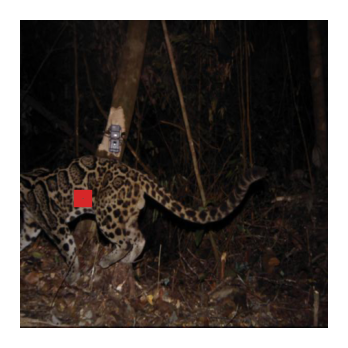

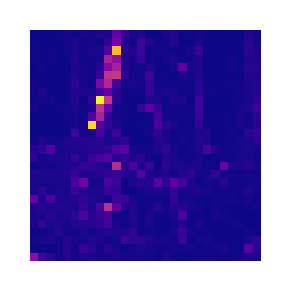

In [137]:
# visualize attns with samples
import matplotlib.pyplot as plt

import numpy as np

def restore(xs, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    mean, std = np.array(mean), np.array(std)
    mean, std = mean.reshape([1, 3, 1, 1]), std.reshape([1, 3, 1, 1])
    return torch.clamp((xs * std) + mean, min=0.0, max=1.0)

def mark_token(ax, xs, batch, i, j, color='tab:red'):
    import matplotlib.patches as patches
    from einops import rearrange, reduce, repeat
    
    
    ax.imshow(rearrange(restore(xs.cpu())[batch], 'c h w -> h w c'))
    ax.set_axis_off()

    # create a rectangle patch to visualize the query token
    rect = patches.Rectangle((14 * i, 14 * j), 14, 14, linewidth=3, edgecolor=color, facecolor='none')
    ax.add_patch(rect)

def visualize_attn(ax, attns, batch, i, j, depth, head):
    """
    ax: matplotlib axes
    xs: batch
    batch, i, j: batch coords 
    attns, depth, head: 
    """
    
    attn_list = [list(attn[batch].cpu()) if attn is not None else None for attn in attns]
    attn = torch.stack(attn_list[depth])
    attn = attn[head]  # take head-th head
    attn = attn[1:,1:]  # drop cls token
    attn = attn / attn.sum(dim=-1, keepdim=True)  # normalize

    attn = attn[j * 14 + i]
    print(attn.shape)
    attn = attn.reshape([28, 28])

    ax.imshow(attn, cmap="plasma", )
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_axis_off()
    
    
#@markdown Execute this cell to visualize the attention maps. The red square in the visualization indicates the location of the query.
#@markdown 
#@markdown This visualization demonstrates that the self-attentions of CL (MoCo) generally captures global relationships and objects. However, they tend to produce homogeneous attention maps for all query tokens and heads, particularly when compared to MIM. In contrast, the self-attentions of MIM (SimMIM) primarily focus on localized areas.

model_option = "mae"  #@param ["moco", "simmim"]
depth = 11  #@param {type:"slider", min:0, max:11, step:1}
batch = 14  #@param {type:"integer"}
coord_x = 6  #@param {type:"integer"}
coord_y = 18  #@param {type:"integer"}
head = 0  #@param {type:"integer"}

if model_option == "dino":
    model = dino
elif model_option == "mae":
    model = mae
else:
    raise Exception("Invalid option: ", model_option)
model.eval()

xs, ys, _ = next(iter(dataset_test_ood))
with torch.no_grad():
    xs = xs.cuda()
    _, attns = model.get_intermediate_layers(xs, return_attention=True)

fig, ax = plt.subplots(1, 1, figsize=(2, 2), dpi=200)
mark_token(ax, xs, batch=batch, i=coord_x, j=coord_y, color='tab:red')

fig, ax = plt.subplots(1, 1, figsize=(1, 1), dpi=300)
visualize_attn(ax, attns, batch=batch, i=coord_x, j=coord_y, depth=depth, head=head)

## Attention Distance

In [ ]:
# build off the implementation of https://github.com/sayakpaul/probing-vits
import numpy as np

def compute_distance_matrix(patch_size, num_patches, length):
    """Helper function to compute distance matrix."""
    distance_matrix = np.zeros((num_patches, num_patches))
    for i in range(num_patches):
        for j in range(num_patches):
            if i == j: # zero distance
                continue

            xi, yi = (int(i/length)), (i % length)
            xj, yj = (int(j/length)), (j % length)
            distance_matrix[i, j] = patch_size * np.linalg.norm([xi - xj, yi - yj])

    return distance_matrix

def calculate_mean_attention_dist(patch_size, attention_weights):
    """ The attention_weights shape = (batch, num_heads, num_patches, num_patches)"""
    
    num_patches = attention_weights.shape[-1]
    length = int(np.sqrt(num_patches))
    assert (length**2 == num_patches), ("Num patches is not perfect square")

    distance_matrix = compute_distance_matrix(patch_size, num_patches, length)
    h, w = distance_matrix.shape

    distance_matrix = distance_matrix.reshape((1, 1, h, w))
    # The attention_weights along the last axis adds to 1
    # this is due to the fact that they are softmax of the raw logits
    # summation of the (attention_weights * distance_matrix)
    # should result in an average distance per token
    mean_distances = attention_weights * distance_matrix
    mean_distances = np.sum(mean_distances, axis=-1) # sum along last axis to get average distance per token
    mean_distances = np.mean(mean_distances, axis=-1) # now average across all the tokens

    return torch.tensor(mean_distances)


#@markdown Execute this cell to calculate attention distance. Attention distance is defined as the average distance between the query tokens and key tokens considering their self-attention weights. Therefore, it conceptually corresponds to the size of the receptive fields in CNNs.
#@markdown 
#@markdown These results shows that the attention distance of CL (MoCo) is significantly higher than that of MIM (SimMIM), especially in the later layers. As seen above, the qualitative visualization, this implies that the representations of CL contain global patterns and shape information, so CL can help ViTs distinguish between objects of images. Conversely, the self-attentions of MIM mainly capture local relationships; i.e., MIM may have difficulty recognizing whole objects and their shapes.

from timm.utils import AverageMeter

model_option = "dino"  #@param ["moco", "simmim"]
if model_option == "dino":
    model = dino
elif model_option == "mae":
    model = mae
else:
    raise Exception("Invalid option: ", model_option)
    
model.eval()

encoder_length = len(model.blocks)  # for example 12 for ViT-B
distances = [AverageMeter() for _ in range(encoder_length)]

for idx, (xs, _, _) in enumerate(dataset_test):
    xs = xs.cuda()
    
    with torch.no_grad():
        _, attns = model.get_intermediate_layers(xs, return_attention=True)
        
    for i, attn in enumerate([attn for attn in attns if attn is not None]):    
        attn = attn[:,:,1:,1:]
        attn = attn + 1e-32
        attn = attn / attn.sum(dim=-1, keepdim=True)  # normalize
        attn = attn.cpu().float().detach().numpy()

        distance = calculate_mean_attention_dist(patch_size=16, attention_weights=attn)
        distances[i].update(torch.mean(distance, dim=0))  # average w.r.t. batch
        
    if idx > -1:
        break
    

fig, ax = plt.subplots(1, 1, figsize=(4.3, 4), dpi=150)
distances = [torch.mean(distance.avg) for distance in distances]
ax.plot(range(1, 13), distances, marker="o")
ax.set_xlabel("Depth")
ax.set_ylabel("Attention distance (px)")
ax.set_ylim(top=250, bottom=0)
plt.show()

In [ ]:
distances_dino_id = distances

In [143]:
distances_dino_ood = distances

In [141]:
distances_mae_ood = distances

In [139]:
distances_mae_id = distances

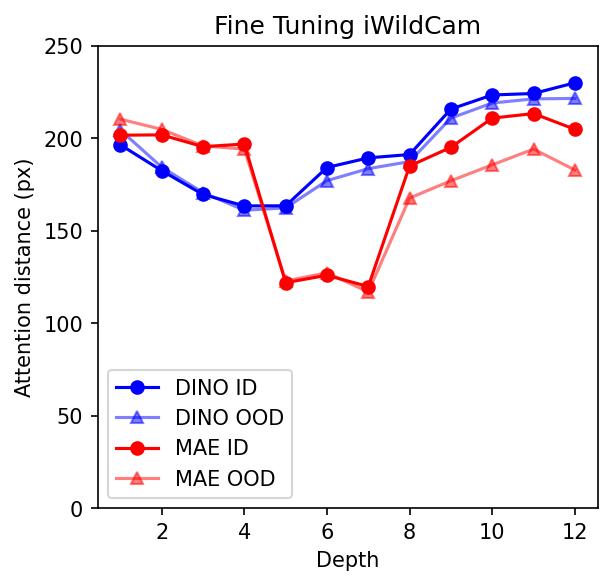

In [146]:
fig, ax = plt.subplots(1, 1, figsize=(4.3, 4), dpi=150)
ax.plot(range(1, 13), distances_dino_id, marker="o", c="b", label="DINO ID")
ax.plot(range(1, 13), distances_dino_ood, marker="^", c="b", alpha=0.5, label="DINO OOD")
ax.plot(range(1, 13), distances_mae_id, marker="o", c="r", label="MAE ID")
ax.plot(range(1, 13), distances_mae_ood, marker="^", c="r", alpha=0.5, label="MAE OOD")
ax.legend()
ax.set_xlabel("Depth")
ax.set_ylabel("Attention distance (px)")
ax.set_ylim(top=250, bottom=0)
ax.set_title("Fine Tuning iWildCam")
plt.show()

## Normalized Mutual Information

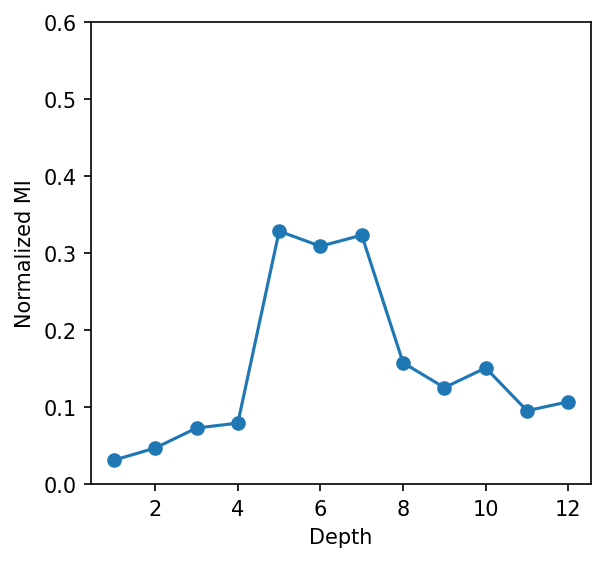

In [156]:
import torch.nn.functional as F 
from einops import rearrange, reduce, repeat

def calculate_nmi(attn): 
    """ Normalized mutual information with a return type of (batch, head) """
    b, h, q, k = attn.shape
    pq = torch.ones([b, h, q]).to(attn.device)
    pq = F.softmax(pq, dim=-1)
    pq_ext = repeat(pq, "b h q -> b h q k", k=k)
    pk = reduce(attn * pq_ext, "b h q k -> b h k", "sum")
    pk_ext = repeat(pk, "b h k -> b h q k", q=q)
    
    mi = reduce(attn * pq_ext * torch.log(attn / pk_ext), "b h q k -> b h", "sum")
    eq = - reduce(pq * torch.log(pq), "b h q -> b h", "sum")
    ek = - reduce(pk * torch.log(pk), "b h k -> b h", "sum")
    
    nmiv = mi / torch.sqrt(eq * ek)
    
    return nmiv

#@markdown Execute this cell to calculate the Normalized Mutual Information (NMI). NMI measures the inhomogeneity of self-attentions with respect to queries. In other words, *attention collapse* occurs when the NMI approaches zero.
#@markdown 
#@markdown The results indicate that the mutual information of CL is significantly lower than that of MIM, especially in the later layers. This suggests that the self-attentions of CL tend to collapse into homogeneous distributions.


from timm.utils import AverageMeter

model_option = "mae"  #@param ["moco", "simmim"]
if model_option == "dino":
    model = dino
elif model_option == "mae":
    model = mae
else:
    raise Exception("Invalid option: ", model_option)
model.eval()
encoder_length = len(model.blocks)  # 12 for ViT-B
nmis = [AverageMeter() for _ in range(encoder_length)]

for idx, (xs, _, _) in enumerate(dataset_test):
    xs = xs.cuda()
    
    with torch.no_grad():
        _, attns = model.get_intermediate_layers(xs, return_attention=True)
        
    for i, attn in enumerate([attn for attn in attns if attn is not None]):
        attn = attn[:,:,1:,1:]  # drop cls token
        attn = attn + 1e-8
        attn = attn / attn.sum(dim=-1, keepdim=True)  # normalize
        attn = attn.cpu().float()
        
        nmi = calculate_nmi(attn)
        nmis[i].update(torch.mean(nmi, dim=0))  # average w.r.t. batch
        
    if idx > -1:
        break
    
    
fig, ax = plt.subplots(1, 1, figsize=(4.3, 4), dpi=150)
nmis = [torch.mean(nmi.avg) for nmi in nmis]
ax.plot(range(1, 13), nmis, marker="o")
ax.set_xlabel("Depth")
ax.set_ylabel("Normalized MI")
ax.set_ylim(top=0.6, bottom=0.0)
plt.show()

In [151]:
dino_nmi_id_lp = nmis

In [153]:
dino_nmi_ood_lp = nmis

In [155]:
mae_nmi_ood_lp = nmis

In [157]:
mae_nmi_id_lp = nmis

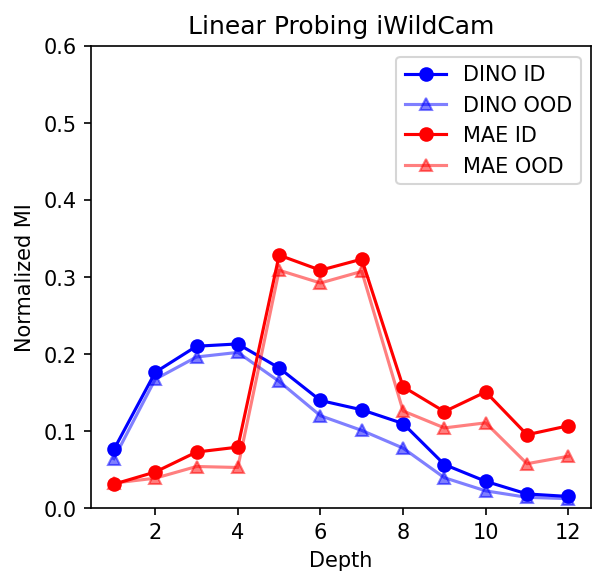

In [158]:
fig, ax = plt.subplots(1, 1, figsize=(4.3, 4), dpi=150)
ax.plot(range(1, 13), dino_nmi_id_lp, marker="o", c="b", label="DINO ID")
ax.plot(range(1, 13), dino_nmi_ood_lp, marker="^", c="b", alpha=0.5, label="DINO OOD")
ax.plot(range(1, 13), mae_nmi_id_lp, marker="o", c="r", label="MAE ID")
ax.plot(range(1, 13), mae_nmi_ood_lp, marker="^", c="r", alpha=0.5, label="MAE OOD")

ax.set_xlabel("Depth")
ax.set_ylabel("Normalized MI")
ax.set_ylim(top=0.6, bottom=0.0)
ax.set_title("Linear Probing iWildCam")
ax.legend()
plt.show()

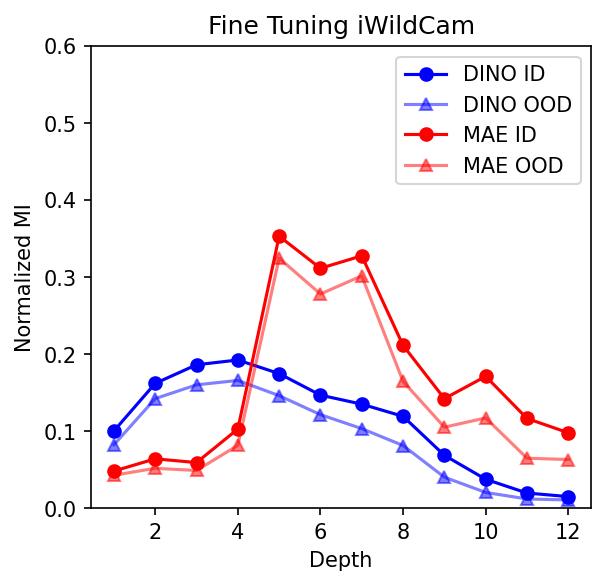

In [134]:
fig, ax = plt.subplots(1, 1, figsize=(4.3, 4), dpi=150)
ax.plot(range(1, 13), dino_nmi_id, marker="o", c="b", label="DINO ID")
ax.plot(range(1, 13), dino_nmi_ood, marker="^", c="b", alpha=0.5, label="DINO OOD")
ax.plot(range(1, 13), mae_nmi_id, marker="o", c="r", label="MAE ID")
ax.plot(range(1, 13), mae_nmi_ood, marker="^", c="r", alpha=0.5, label="MAE OOD")

ax.set_xlabel("Depth")
ax.set_ylabel("Normalized MI")
ax.set_ylim(top=0.6, bottom=0.0)
ax.set_title("Fine Tuning iWildCam")
ax.legend()
plt.show()